In [1]:
import joblib
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model

model_dir = 'model_data'

model_name1 = 'Seq_2Layer_32_64_ReLU_Adam'
model_name2 = 'Deep_3Layer_64_128_64_ReLU_Adam'
model_name3 = 'Deep_3Layer_128_256_128_ReLU_Adam'
model_name4 = 'Simple_1Layer_32_ReLU_Adam'
model_name5 = 'Complex_4Layer_128_256_256_128_ReLU_Adam'

sel_model = model_name5

# Load the model
model_path = f'{model_dir}/{sel_model}/model.keras'
model = load_model(model_path)

# Load the label encoder
le_path = f'{model_dir}/{sel_model}/label_encoder.joblib'
le = joblib.load(le_path)

# Initialize the cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

folds = 5

2024-05-13 16:03:11.588402: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-13 16:03:11.593084: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-13 16:03:11.658322: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 16:03:12.691161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from preprocessing import load_and_preprocess_data
import pandas as pd
from plotting import plot_metrics, plot_history, plot_confusion_matrices, plot_model_metrics
from evaluation import evaluate_and_append_accuracy

# Load and preprocess the data
X, y, le = load_and_preprocess_data()

# Get the class labels
class_labels = le.classes_

# Initialize lists to store metrics
metrics = []

# Directory to store the model data
model_dir = 'model_data'


# Initialize lists to store importances and standard deviations for each fold
all_importances = []
all_std = []

# Cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    # Load the model
    model_path = f'{model_dir}/{sel_model}/model.keras'
    model = load_model(model_path)

    # Load the label encoder
    le_path = f'{model_dir}/{sel_model}/label_encoder.joblib'
    le = joblib.load(le_path)

    # Load the test data
    test_data_path = f'{model_dir}/{sel_model}/test_data_fold_{fold}.joblib'
    X_test, y_test_categorical = joblib.load(test_data_path)

    # Evaluate the model and append the accuracy to the list
    evaluate_and_append_accuracy(model, sel_model, X_test, y_test_categorical, metrics, fold)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step


In [ ]:
# Load the histories from csv
histories = [pd.read_csv(
    f'results/{sel_model}/csv/history_fold_{fold}.csv') for fold in range(1, kf.get_n_splits() + 1)]
folds = list(range(1, kf.get_n_splits() + 1))

# Plot the histories
plot_history(histories, folds, sel_model)

# Plot the metrics
plot_metrics(metrics, sel_model)

# Extract confusion matrices from accuracies
confusion_matrices = [metrics['confusion_matrix'] for metrics in metrics]

# Plot the confusion matrices
plot_confusion_matrices(confusion_matrices, sel_model, class_labels)

In [ ]:
# Plot the comparison of all tested models
plot_model_metrics()

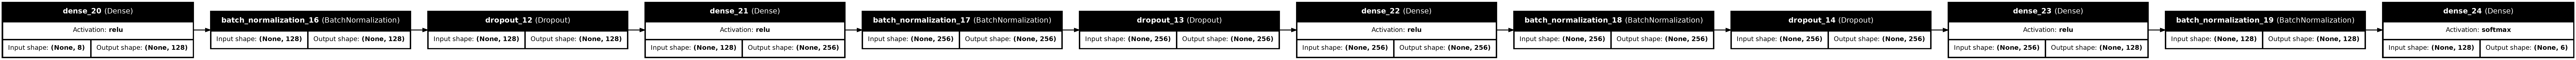

In [2]:
# Architecture Model Visualization
from tensorflow.keras.utils import plot_model


# Plot the model
mod_plot_path = f'results/{sel_model}/{sel_model}_model_plot.png'
orient = 'LR' if '4Layer' in sel_model else 'TB' # orientation of the plot

plot_model(model, to_file=mod_plot_path, show_shapes=True, show_layer_names=True, show_dtype=False, expand_nested=True, show_layer_activations=True, rankdir=orient)

# Print the model summary
# print(model.summary())


In [ ]:
# Explainability with Permutation Feature Importance

from explainabilty import explain_model_with_pfi, keras_score

# Initialize lists to store importances and standard deviations for each fold
all_importances = []
all_std = []

for fold in range(1, folds + 1):
    # Load the test data
    test_data_path = f'{model_dir}/{sel_model}/test_data_fold_{fold}.joblib'
    X_test, y_test_categorical = joblib.load(test_data_path)
    
    # Get feature names
    feature_names = X_test.columns

    # Explain the model with Permutation Feature Importance
    importances, std, indices = explain_model_with_pfi(model, sel_model, X_test, y_test_categorical, fold, keras_score, feature_names, all_importances=all_importances, all_std=all_std)

    # Append the importances and standard deviations to the lists
    all_importances.append(importances)
    all_std.append(std)
    
# After the cross-validation loop, generate the combined plot
explain_model_with_pfi(None, sel_model, None, None, None, None, feature_names, all_importances=all_importances, all_std=all_std)